In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import factorial
from random import choices, shuffle, choice
from sklearn.model_selection import train_test_split

import cv2

import os

import albumentations as A

In [19]:
%matplotlib inline

In [267]:
def c(a, b):
    return factorial(a) // (factorial(b) * factorial(a - b))

In [2]:
PROJECT_PATH = '/Users/danil/AIJ_2024'
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
DATASET_PATH = os.path.join(DATA_PATH, 'full_pipes_dataset')

_paths = [PROJECT_PATH, DATA_PATH, DATASET_PATH]

for path in _paths:
	if not os.path.exists(path):
		print(path, 'does not exist')

## Work with angle pipes

In [23]:
def show_image(image: np.ndarray, bboxes=None):
    image_draw = np.ascontiguousarray(image, dtype=np.uint8).copy()
    shape = image_draw.shape
    if bboxes is not None:
        for x, y, w, h, _ in bboxes:
            width, heigth = w * shape[1], h * shape[0]
            start_x = round(x * shape[1] - width / 2)
            start_y = round(y * shape[0] - heigth / 2)
            end_x = round(x * shape[1] + width / 2)
            end_y = round(y * shape[0] + heigth / 2)
            image_draw = cv2.rectangle(image_draw, (start_x, start_y), (end_x, end_y), (0, 240, 0), 1)

    plt.imshow(image_draw)
    plt.title(f'{image_draw.shape[1]} x {image_draw.shape[0]}')
    plt.axis('off')
    plt.show()

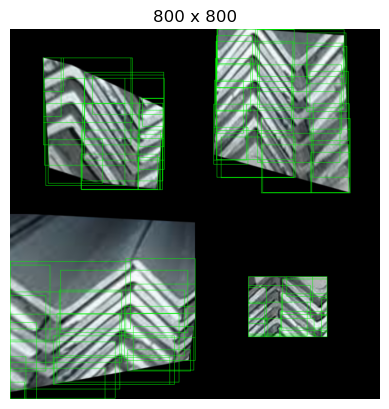

In [295]:
show_image(cropped_images, bboxes=cropped_labels)

In [4]:
def normalization_of_names(dataset_path: str):
	images = []
	names = []
	bad_names = []
	for idx, filename in enumerate(os.listdir(dataset_path)):
		full_path = os.path.join(dataset_path, filename)
		new_name = f'image_{idx + 1}.jpeg'
		new_path = os.path.join(dataset_path, new_name)
		
		image = cv2.imread(full_path)
		images.append(image)
		bad_names.append(full_path)
		names.append(new_path)
		
	for name in bad_names:
		os.remove(name)
	
	for name, image in zip(names, images):
		cv2.imwrite(name, image)
		
		
normalization_of_names(DATASET_PATH)

In [50]:
def padding(image: np.ndarray, size: int):
	return cv2.copyMakeBorder(image, size, size, size, size, cv2.BORDER_CONSTANT)


def to_grayscale(image: np.ndarray) -> np.ndarray:
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

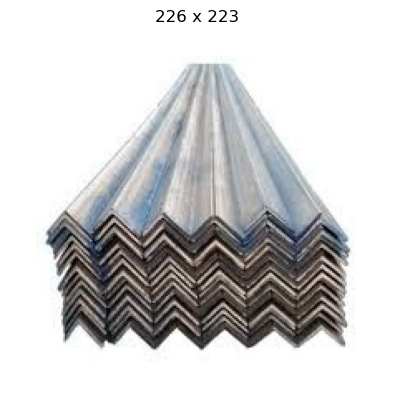

In [112]:
example_name = os.listdir(DATASET_PATH)[1]
example_path = os.path.join(DATASET_PATH, example_name)

image = cv2.imread(example_path)
show_image(image)

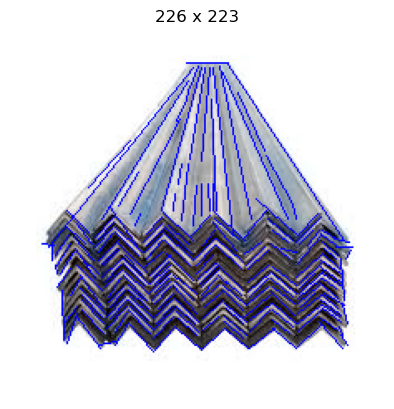

In [113]:
gray = to_grayscale(image)
lsd = cv2.createLineSegmentDetector(0)

# Найдем линии
lines, *_ = lsd.detect(gray)

# Нарисуем найденные линии на изображении
drawn_image = image.copy()
if lines is not None:
    lsd.drawSegments(drawn_image, lines)

show_image(drawn_image)

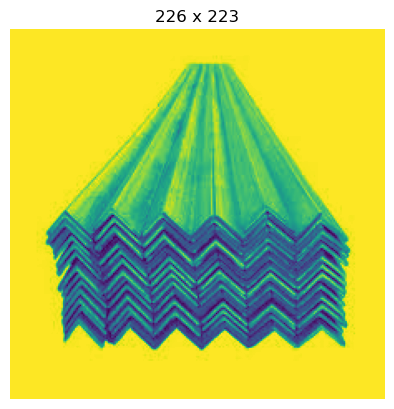

In [114]:
show_image(gray)

In [442]:
def create_dataset(silly_dataset_path: str, save_path: str, num_of_4: int = 10, num_of_1: int = 10) -> tuple[np.ndarray, np.ndarray]:
    silly_labels_path = os.path.join(silly_dataset_path, 'labels')
    silly_images_path = os.path.join(silly_dataset_path, 'images')
    
    def four_in_one(images, labels):
        labels_copy = [i.copy() for i in labels]
        
        width, height = images[0].shape[:2]
        res = np.zeros((2 * height, 2 * width, 3), dtype=int)
        
        res[0:height, 0:width] = images[0]
        res[0:height, width:] = images[1]
        res[height:, 0:width] = images[2]
        res[height:, width:] = images[3]

        for i in range(4):
            labels_copy[i][:, :4] /= 2
        
        labels_copy[1][:, 0] += 0.5
        labels_copy[2][:, 1] += 0.5
        labels_copy[3][:, 0] += 0.5
        labels_copy[3][:, 1] += 0.5
        res_labels = (list(labels_copy[0]) + list(labels_copy[1]) +
        list(labels_copy[2]) + list(labels_copy[3]))
        
        return res, np.array(res_labels)

    def write_bbox(path: str, bboxes):
        with open(path, 'w') as file:
            for data in bboxes:
                new_data = list(data)
                new_data = [new_data[-1]] + new_data[:4]
                print(' '.join(map(str, new_data)), file=file)
        
    def resize_image(image, bboxes, target_width):
        shape = image.shape
        
        t = A.Compose([
            A.LongestMaxSize(max_size=target_width),
        ], bbox_params=A.BboxParams(format='yolo'))
        
        res = t(image=image.astype(np.uint8), bboxes=bboxes)
        
        return res['image'], res['bboxes']
    
    def get_data_from_image_path(single_image_path: str):
        image = cv2.imread(single_image_path)
        dot_index = single_image_path.rfind('.')
        s_indexe = single_image_path.rfind('/')
        
        single_label_name = single_image_path[s_indexe + 1:dot_index] + '.txt'
        single_label_path = os.path.join(silly_labels_path, single_label_name)
        
        bboxes = []
        with open(single_label_path) as file:
            for line in file.readlines():
                data = [float(i) for i in line.strip().split()][1:]
                data.append(0)
                bboxes.append(data)
                
        image, bboxes = resize_image(image, np.array(bboxes), 600)
        return image, bboxes
    
    silly_images = []
    silly_labels = []
    for cur_image_name in os.listdir(silly_images_path):
        cur_image_path = os.path.join(silly_images_path, cur_image_name)
        cur_image, cur_label = get_data_from_image_path(cur_image_path)
        silly_images.append(cur_image)
        silly_labels.append(cur_label)
        
    length = len(silly_images)
    x = 6

    while True:
        count_1 = length * x // 5
        count_4 = c(length * x, 4) // 100
        if count_1 > num_of_1 and count_4 > num_of_4:
            break
        x += 1
        
    print('x =', x)
    wh_list = [
        (200, 150),
        (250, 200),
        (300, 230),
        (170, 130),
        (200, 200),
        (200, 250),
    ] + [(np.random.randint(150, 400), np.random.randint(150, 320)) for _ in range(x - 6)]
    
    transforms_list = []
    for w, h in wh_list:
        t = A.Compose([
            A.RandomCrop(width=w, height=h),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Affine(),
            A.PadIfNeeded(min_width=400, min_height=400, value=0, border_mode=cv2.BORDER_CONSTANT, p=1),
            A.Perspective(scale=(0.1, 0.7))
        ], bbox_params=A.BboxParams(format='yolo', min_area=500))
        transforms_list.append(t)

    cropped_images, cropped_labels = [], []
    for image, label in zip(silly_images, silly_labels):
        for t in transforms_list:
            res = t(image=image, bboxes=label)
            if len(res['bboxes']) > 0:
                cropped_images.append(res['image'])
                cropped_labels.append(res['bboxes'])
            
    final_images, final_labels = [], []
    total_num = len(cropped_images)
    # create 1
    for _ in range(num_of_1):
        idx = np.random.randint(0, total_num - 1)
        image, label = cropped_images[idx], cropped_labels[idx]
        final_images.append(image)
        final_labels.append(label)
        
    # create 2
    for _ in range(num_of_4):
        idxs = choices(range(total_num), k=4)
        images, labels = [cropped_images[i] for i in idxs], [cropped_labels[i] for i in idxs]
        four_image, four_label = four_in_one(images, labels)
        final_images.append(four_image)
        final_labels.append(four_label)
    
    indexes = list(range(len(final_labels)))
    shuffle(indexes)
    shuffled_images, shuffled_labels = [], []
    for idx in indexes:
        si, sl = resize_image(final_images[idx], final_labels[idx], 640)
        shuffled_images.append(si)
        shuffled_labels.append(sl)
        
    if os.path.exists(save_path):
        os.system(f'rm -R {save_path}')
    
    os.mkdir(save_path)
    train_path = os.path.join(save_path, 'train')
    train_image_path = os.path.join(train_path, 'images')
    train_labels_path = os.path.join(train_path, 'labels')
    
    val_path = os.path.join(save_path, 'val')
    val_image_path = os.path.join(val_path, 'images')
    val_labels_path = os.path.join(val_path, 'labels')
    
    os.mkdir(train_path)
    os.mkdir(train_image_path)
    os.mkdir(train_labels_path)
    os.mkdir(val_path)
    os.mkdir(val_image_path)
    os.mkdir(val_labels_path)
    
    images_train, images_val, labels_train, labels_val = train_test_split(
        shuffled_images, shuffled_labels, random_state=42, shuffle=True, test_size=0.1,
    )
    
    for i, (image, label) in enumerate(zip(images_train, labels_train)):
        name = f'sample_{i + 1}.'
        image_path = os.path.join(train_image_path, name + 'jpeg')
        label_path = os.path.join(train_labels_path, name + 'txt')
        
        cv2.imwrite(image_path, image)
        write_bbox(label_path, label)
        
    for i, (image, label) in enumerate(zip(images_val, labels_val)):
        name = f'sample_{i + 1}.'
        image_path = os.path.join(val_image_path, name + 'jpeg')
        label_path = os.path.join(val_labels_path, name + 'txt')
        
        cv2.imwrite(image_path, image)
        write_bbox(label_path, label)
        
    with open(os.path.join(save_path, 'data.yaml'), 'w') as file:
        print("""train: ../train/images
val: ../val/images

nc: 1
names: ['Angle']""", file=file)
    
    return shuffled_images, shuffled_labels
   

path = '/Users/danil/AIJ_2024/data/test_angle_bar'
cropped_images, cropped_labels = create_dataset(path, '/Users/danil/AIJ_2024/data/strong_dataset_from_1_image', 20, 100)

x = 505


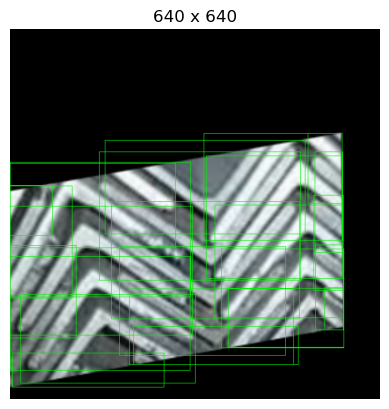

In [434]:
idx = 1
show_image(cropped_images[idx], bboxes=cropped_labels[idx])

In [47]:
class Augmentator:
    def __init__(self):
        self.size = 640
        self.base_bbox_params = A.BboxParams(format='yolo')
        
        self.extra_padding_k = 1.75
        self.pad_size = round(self.size * self.extra_padding_k)
        
        self.required_augmentations = {
            'resize': A.Compose([
                A.LongestMaxSize(max_size=self.size, always_apply=True),
            ], bbox_params=self.base_bbox_params),
            
            'padding': A.Compose([
                A.PadIfNeeded(
                    min_height=self.size,
                    min_width=self.size,
                    border_mode=cv2.BORDER_CONSTANT,
                    value=0,
                    always_apply=True
                )
            ], bbox_params=self.base_bbox_params),
            
#             'normalize': A.Compose([
#                 A.Normalize(always_apply=True),
#             ], bbox_params=self.base_bbox_params),
        }
        
        self.extra_padding = A.Compose([
            A.PadIfNeeded(
                min_height=self.pad_size,
                min_width=self.pad_size,
                border_mode=cv2.BORDER_CONSTANT,
                value=0,
                always_apply=True
            )
        ], bbox_params=self.base_bbox_params)
        
        self.affine = A.Compose([
            A.VerticalFlip(p=0.5),
            A.Affine(scale=(0.25, 0.8), always_apply=True),
            A.Perspective(scale=(0.1, 0.6), p=0.35),
        ], bbox_params=self.base_bbox_params)
        
        self.crop = A.Compose([
            A.RandomCrop(height=self.size // 2, width=self.size // 2, always_apply=True),
            A.LongestMaxSize(max_size=self.size, always_apply=True),
        ], bbox_params=A.BboxParams(format='yolo', min_area=10000))
        
        self.path_to_images_for_spacial_padding = '/Users/danil/AIJ_2024/data/zavod_images/'
        self.zavod_image_aug = A.Compose([
            A.SmallestMaxSize(max_size=self.pad_size),
            A.RandomCrop(
                height=self.pad_size,
                width=self.pad_size,
            ),
        ])
        
    def apply_any_augs(self, aug_list, image, bboxes):
        res_image, res_label = image.copy(), bboxes.copy()
        for aug in aug_list:
            res = aug(image=res_image, bboxes=res_label)
            res_image, res_label = res['image'], res['bboxes']
        
        return {'image': res_image, 'bboxes': res_label} 
        
    def spacial_padding(self, image, bboxes):
        zavod_image_name = choice(os.listdir(self.path_to_images_for_spacial_padding))
        zavod_image_path = os.path.join(self.path_to_images_for_spacial_padding, zavod_image_name)
        zavod_image = cv2.imread(zavod_image_path)
        zavod_image = self.zavod_image_aug(image=zavod_image)['image']
        
        res = self.extra_padding(image=image, bboxes=bboxes)
        padded_image, padded_labels = res['image'], res['bboxes']
        mask = padded_image.sum(axis=2) == 0
        zavod_image[~mask] *= 0
        zavod_image = zavod_image.astype(np.uint8)
        padded_image += zavod_image
        
        return {'image': padded_image, 'bboxes': padded_labels}
    
    def pad_image(self, image, bboxes, p_default=0.5):
        if np.random.random() < p_default:
            return self.extra_padding(image=image, bboxes=bboxes)
        
        return self.spacial_padding(image, bboxes)
        
    def apply_aug_to_list_of_samples(self, aug, images: list[np.ndarray], labels: list[np.ndarray]):
        result_images = []
        result_lables = []
        for image, label in zip(images, labels):
            result = aug(image=image, bboxes=label)
            result_images.append(result['image'])
            result_lables.append(result['bboxes'])
        
        return result_images, result_lables
    
    def __call__(self, images: list[np.ndarray], labels: list[np.ndarray], p_pad, p_affine, p_crop):        
        start_images, start_labels = images.copy(), labels.copy()
        for aug in self.required_augmentations.values():
            start_images, start_labels = self.apply_aug_to_list_of_samples(aug, start_images, start_labels)
        
        result_images, result_labels = [], []
        for image, label in zip(images, labels):
            if label:
                result_images.append(image)
                result_labels.append(label)
            else:
                continue
            
            aug_list = []
            if np.random.random() < p_pad:
                aug_list.append([self.pad_image])
            if np.random.random() < p_affine:
                aug_list.append([self.affine])
            if np.random.random() < p_crop:
                aug_list.append([self.crop])
            if np.random.random() < p_pad * p_affine:
                aug_list.append([self.affine, self.pad_image])
            if np.random.random() < p_crop * p_affine:
                aug_list.append([self.crop, self.affine])
            
            for aug in aug_list:
                res = self.apply_any_augs(aug, image, label)
                if res['bboxes']:
                    result_images.append(res['image'])
                    result_labels.append(res['bboxes'])
        
        for aug in self.required_augmentations.values():
            result_images, result_labels = self.apply_aug_to_list_of_samples(aug, result_images, result_labels)
        
        return result_images, result_labels

In [50]:
def create_yolo_dataset(path: str, save_path: str):
    labels_path = os.path.join(path, 'labels')
    images_path = os.path.join(path, 'images')
    augmentator = Augmentator()
    
    def get_data_from_image_path(single_image_path: str):
        image = cv2.imread(single_image_path)
        dot_index = single_image_path.rfind('.')
        s_indexe = single_image_path.rfind('/')
        
        single_label_name = single_image_path[s_indexe + 1:dot_index] + '.txt'
        single_label_path = os.path.join(labels_path, single_label_name)
        
        bboxes = []
        kind = int(single_image_path[dot_index - 1])
        with open(single_label_path) as file:
            for line in file.readlines():
                data = [float(i) for i in line.strip().split()][1:]
                data.append(kind)
                bboxes.append(data)
                
        return image, bboxes
    
    def write_bbox(path: str, bboxes):
        with open(path, 'w') as file:
            for data in bboxes:
                new_data = list(data)
                new_data = [int(new_data[-1]) - 1] + new_data[:4]
                print(' '.join(map(str, new_data)), file=file)
    
    images, labels = [], []
    for name in os.listdir(images_path):
        single_image_path = os.path.join(images_path, name)
        image, bboxes = get_data_from_image_path(single_image_path)
        
        images.append(image)
        labels.append(bboxes)

    image_train, image_test, labels_train, labels_test = train_test_split(
        images, labels, random_state=52, shuffle=True, test_size=0.3,
    )
    image_val, image_test, labels_val, labels_test = train_test_split(
        image_test, labels_test, random_state=52, shuffle=True, test_size=0.2,
    )
    
    image_train, labels_train = augmentator(image_train, labels_train, 0.3, 0.3, 0.2)
    
    if os.path.exists(save_path):
        os.system(f'rm -R {save_path}')
    
    os.mkdir(save_path)
    
    paths = {name: os.path.join(save_path, name) for name in ['train', 'val', 'test']}
    for path in paths.values():
        os.mkdir(path)
        os.mkdir(os.path.join(path, 'images'))
        os.mkdir(os.path.join(path, 'labels'))
    
    image_path = os.path.join(paths['val'], 'images')
    label_path = os.path.join(paths['val'], 'labels')
    for i, (image, label) in enumerate(zip(image_val, labels_val)):
        name = f'sample_{i + 1}.'
        cur_image_path = os.path.join(image_path, name + 'jpeg')
        cur_label_path = os.path.join(label_path, name + 'txt')
        
        cv2.imwrite(cur_image_path, image)
        write_bbox(cur_label_path, label)
        
    image_path = os.path.join(paths['test'], 'images')
    label_path = os.path.join(paths['test'], 'labels')
    for i, (image, label) in enumerate(zip(image_test, labels_test)):
        name = f'sample_{len(image_val) + i + 1}.'
        cur_image_path = os.path.join(image_path, name + 'jpeg')
        cur_label_path = os.path.join(label_path, name + 'txt')
        
        cv2.imwrite(cur_image_path, image)
        write_bbox(cur_label_path, label)
        
    image_path = os.path.join(paths['train'], 'images')
    label_path = os.path.join(paths['train'], 'labels')
    for i, (image, label) in enumerate(zip(image_train, labels_train)):
        name = f'sample_{len(image_val) + len(image_test) + i + 1}.'
        cur_image_path = os.path.join(image_path, name + 'jpeg')
        cur_label_path = os.path.join(label_path, name + 'txt')
        
        cv2.imwrite(cur_image_path, image)
        write_bbox(cur_label_path, label)
        
    return image_train, labels_train

In [51]:
path = '/Users/danil/AIJ_2024/data/my_dataset/'
images, labels = create_yolo_dataset(path, '/Users/danil/AIJ_2024/data/yolo_dataset_cs000_01')

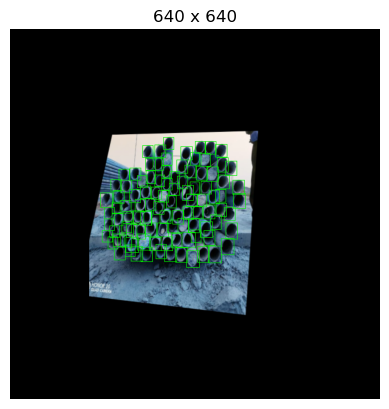

In [425]:
idx = 45
show_image(images[idx], labels[idx])

In [360]:
images[2].min()

-2.117904